In [2]:
%matplotlib inline

# simple_convnet.py

In [4]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """単純なConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

# train_convnet.py.py

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


train loss:2.2993629555484585
=== epoch:1, train acc:0.183, test acc:0.212 ===
train loss:2.2963962298299343
train loss:2.2919979477008052
train loss:2.2840232935136155
train loss:2.273761294888323
train loss:2.262944675830066
train loss:2.2492385989118904
train loss:2.2267228615780903
train loss:2.199127454662418
train loss:2.1733775059799654
train loss:2.1273370031308194
train loss:2.102845087596542
train loss:2.0264428055818406
train loss:1.9936496869276694
train loss:1.9840400147276531
train loss:1.8210268943185446
train loss:1.7651560368343509
train loss:1.7194399217992478
train loss:1.6355692853175143
train loss:1.5724793374675303
train loss:1.4401725754125863
train loss:1.4373563408435315
train loss:1.3949845502753797
train loss:1.3145129389335142
train loss:1.1837445276022063
train loss:0.8901981838678741
train loss:1.0522915548189842
train loss:0.9275275581127737
train loss:1.0025057434623077
train loss:0.9570069651336657
train loss:0.7668028351257881
train loss:0.689851430519

train loss:0.16877647281777647
train loss:0.20743010168366227
train loss:0.2149716583758602
train loss:0.25108118208548624
train loss:0.35147629182109874
train loss:0.27888209462159674
train loss:0.3281157656195215
train loss:0.19580965868991507
train loss:0.24680795797497293
train loss:0.28326365593782343
train loss:0.18071189152424647
train loss:0.21961802197554547
train loss:0.21008650393285866
train loss:0.2844683994421229
train loss:0.1954876127823148
train loss:0.2798854182759506
train loss:0.24646297304320086
train loss:0.20744379055462125
train loss:0.189481078562706
train loss:0.5679889973376717
train loss:0.25702700899306447
train loss:0.10428366104556554
train loss:0.12307827244296758
train loss:0.3510170658691331
train loss:0.26140244109733285
train loss:0.17126025803682032
train loss:0.13361575968918568
train loss:0.34642442046393573
train loss:0.281144402159341
train loss:0.21391236736240862
train loss:0.20651976050546098
train loss:0.3286797563206584
train loss:0.1603122

train loss:0.13091578378809107
train loss:0.12958541836782808
train loss:0.1324725582609534
train loss:0.1233837049737056
train loss:0.11457505632534337
train loss:0.07752622614792606
train loss:0.05158865887979343
train loss:0.15680517370170943
train loss:0.06215409819432223
train loss:0.1271208801045695
train loss:0.1734384258189791
train loss:0.09749482720159168
train loss:0.042180315773785386
train loss:0.1826285602251531
train loss:0.1318427646780537
train loss:0.15683261056513062
train loss:0.07259129419240842
train loss:0.06023705461482095
train loss:0.13409320375274164
train loss:0.08476167097382867
train loss:0.11351002735520288
train loss:0.13080783197396872
train loss:0.0562819577919035
train loss:0.12960431153200364
train loss:0.09100160417456758
train loss:0.18877083076006168
train loss:0.08522737324965518
train loss:0.13105072870548984
train loss:0.16138586806382474
train loss:0.08991699379698309
train loss:0.05426870144455507
train loss:0.08001374875853953
train loss:0.1

train loss:0.08560020353211938
train loss:0.08033177668870276
train loss:0.07061427667382426
train loss:0.08672415471977757
train loss:0.03473936641571416
train loss:0.0635247537307914
train loss:0.07976534441718208
train loss:0.03557267459021414
train loss:0.09084631951771417
train loss:0.07633595567325589
train loss:0.10491201409257958
train loss:0.03847136269827096
train loss:0.04765218039231638
train loss:0.1518178900572391
train loss:0.0431585338181204
train loss:0.08143247098624551
train loss:0.06261693631584705
train loss:0.05303288397125945
train loss:0.18057126764758816
train loss:0.061884753106693016
train loss:0.10310664254469554
train loss:0.06233399021638311
train loss:0.08533558578929958
train loss:0.10272238068427583
train loss:0.085438694660938
train loss:0.10129016673064477
train loss:0.021084892129465026
train loss:0.1202453767457
train loss:0.04172091922837857
train loss:0.023420545909997665
train loss:0.07493234427725662
train loss:0.09311121340245634
train loss:0.1

train loss:0.03766294886393543
train loss:0.0870106794336441
train loss:0.05442956864914412
train loss:0.032548072116347464
train loss:0.055406981235122166
train loss:0.048389699199765046
train loss:0.12743970650748834
train loss:0.009937806997408592
train loss:0.03961723360035432
train loss:0.08673644396037374
train loss:0.07892528705194558
train loss:0.02827431678099102
train loss:0.0669276788238447
train loss:0.052587041477654244
train loss:0.041447072505443126
train loss:0.07352646557862758
train loss:0.054746149167591095
train loss:0.03895599864817495
train loss:0.1358701758003381
train loss:0.0765950617384132
train loss:0.08410885268002787
train loss:0.07470903080973545
train loss:0.026299936327728785
train loss:0.052525391278577124
train loss:0.11905395129726787
train loss:0.04128412496062305
train loss:0.1274156958339588
train loss:0.036957367298066764
train loss:0.14149917507334592
train loss:0.10018378969698595
train loss:0.039978906184382296
train loss:0.038554305975885515
t

train loss:0.023586116470470483
train loss:0.021988506656421557
train loss:0.03825085019390456
train loss:0.04584152851625494
train loss:0.031089981901321527
train loss:0.027835525632060983
train loss:0.013776570896234323
train loss:0.006386601861065745
train loss:0.13043515684610826
train loss:0.11633664355826599
train loss:0.023877375492673734
train loss:0.043839628836612986
train loss:0.013732171032961347
train loss:0.026474457403689734
train loss:0.05308320240124675
train loss:0.01860711145110025
train loss:0.06852689302118319
train loss:0.08454375001964498
train loss:0.051296239295422534
train loss:0.09488493361171386
train loss:0.01860331786294768
train loss:0.1273551638076837
train loss:0.022710598432869582
train loss:0.2031851730139001
train loss:0.033660935185880786
train loss:0.016314753308765625
train loss:0.0866085403263402
train loss:0.0402172243224912
train loss:0.02093019645004035
train loss:0.0791189218636813
train loss:0.04527130026601444
train loss:0.02272560383938412

train loss:0.016508456599643853
train loss:0.025539762363031397
train loss:0.0519646851704402
train loss:0.03264943016991287
train loss:0.06925237154727407
train loss:0.01615153801915823
train loss:0.07170246216977633
train loss:0.026095466692726096
train loss:0.03874430904884876
train loss:0.010282800500835758
train loss:0.05704442009903609
train loss:0.012356884226593765
train loss:0.05495549150178308
train loss:0.051791027367737046
train loss:0.07229670430175665
train loss:0.03862533251294657
train loss:0.041872304566826495
train loss:0.030634090909342597
train loss:0.05719554633941576
train loss:0.027983435571263437
train loss:0.02137457658372827
train loss:0.011225028274269527
train loss:0.05801764636553572
train loss:0.02766171198791134
train loss:0.07395343359341087
train loss:0.02574165779309182
train loss:0.02641286378390523
train loss:0.07541330080787977
train loss:0.03701714109720138
train loss:0.08471858544105888
train loss:0.05509282992575443
train loss:0.01126712910241124

train loss:0.0209497024860702
train loss:0.07831917891551249
train loss:0.04182985971772192
train loss:0.04376568915175495
train loss:0.06765266897278828
train loss:0.024344146207867096
train loss:0.06429134299473596
train loss:0.020115578770175647
train loss:0.034756310103837375
train loss:0.09037857559523124
train loss:0.18373193307865524
train loss:0.05752007366567324
train loss:0.186405247119715
train loss:0.07834634385154471
train loss:0.016640449740011637
train loss:0.020725352424070535
train loss:0.032937317899527335
train loss:0.0406920532819576
train loss:0.08007944050298565
train loss:0.045033999303912366
train loss:0.02092748882502059
train loss:0.039233737763278945
train loss:0.011972088108914966
train loss:0.06855076402085382
train loss:0.025507545679422598
train loss:0.02484839459567015
train loss:0.07734510809147001
train loss:0.09751524758040576
train loss:0.02881304195652934
train loss:0.026457715932569906
train loss:0.01065227243910951
train loss:0.02028839909215907
t

train loss:0.04018148902923878
train loss:0.006384330055370858
train loss:0.01002507345579477
train loss:0.024907221849831705
train loss:0.07778483036329942
train loss:0.02547818091808308
train loss:0.09267682008105856
train loss:0.014366262160861357
train loss:0.03278269377166851
train loss:0.01361758662200692
train loss:0.05954733529881951
train loss:0.008409439322837432
train loss:0.06531654218127922
train loss:0.06475816593065305
train loss:0.05949555593208828
train loss:0.013016828851920766
train loss:0.0253498759971625
train loss:0.009414247829442661
train loss:0.07586545592670518
train loss:0.033456766187911664
train loss:0.11401252451157542
train loss:0.01870705446511167
train loss:0.010151242878107989
train loss:0.020612527745024038
train loss:0.051233626697516604
train loss:0.038693721098372956
train loss:0.06742362428352404
train loss:0.006434414503545245
train loss:0.031059524882916873
train loss:0.016418955738614908
train loss:0.03100220619743336
train loss:0.0278051445595

train loss:0.010182459557070643
train loss:0.03637477026035169
train loss:0.04194682044287485
train loss:0.07353722007227034
train loss:0.030661369113436455
train loss:0.04605631912401966
train loss:0.1006574120205506
train loss:0.02262993535836657
train loss:0.023696243618662783
train loss:0.024198568775576024
train loss:0.00649440534711793
train loss:0.032026493162257405
train loss:0.02835342112554659
train loss:0.018171244325586585
train loss:0.01669816778291233
train loss:0.022355036473566223
train loss:0.030320146096637753
train loss:0.02917675849028671
train loss:0.016384668322207908
train loss:0.04841870798203501
train loss:0.06136677622791468
train loss:0.03367989743721212
train loss:0.02062901929080894
train loss:0.0312160800664198
train loss:0.016315200167873408
train loss:0.013323162250224934
train loss:0.021388977973620188
train loss:0.03080169209384439
train loss:0.007185453431008419
train loss:0.04619292124595424
=== epoch:5, train acc:0.985, test acc:0.979 ===
train loss

train loss:0.0157663550651959
train loss:0.044695301532925155
train loss:0.0066138653070419865
train loss:0.012772969288661364
train loss:0.07292876966654245
train loss:0.004445095553381795
train loss:0.021767582835967896
train loss:0.062044681147329576
train loss:0.017179085781530684
train loss:0.009183382743290435
train loss:0.021388216144172682
train loss:0.07679176664970239
train loss:0.00883830320133638
train loss:0.04997307519447703
train loss:0.028899447576231682
train loss:0.010518319120278117
train loss:0.0345419762970898
train loss:0.03842766804988075
train loss:0.003819429745364567
train loss:0.030523803638128524
train loss:0.007438467424062003
train loss:0.011716307202544678
train loss:0.017386156899738124
train loss:0.03329398781482637
train loss:0.005376932172049665
train loss:0.07749201309558221
train loss:0.024462856379568475
train loss:0.019432552338226373
train loss:0.0701005634103192
train loss:0.022314746461140608
train loss:0.02053630054286658
train loss:0.03686430

train loss:0.015545369054199745
train loss:0.007989045274811622
train loss:0.0076579494247728894
train loss:0.023055878322092712
train loss:0.026702355157186407
train loss:0.08500440462804763
train loss:0.011844078712789316
train loss:0.0218201778122156
train loss:0.02522269634295665
train loss:0.016085800635929664
train loss:0.025875920366730844
train loss:0.05175360477843202
train loss:0.032119224610831235
train loss:0.042959097163901123
train loss:0.00862184193970045
train loss:0.01381836298807331
train loss:0.03718223968664449
train loss:0.00903671059180285
train loss:0.04113361732265609
train loss:0.020927508132952344
train loss:0.00864963796997719
train loss:0.01770519522747289
train loss:0.020153997186069993
train loss:0.003350578130371401
train loss:0.04085293712629782
train loss:0.0324270446725111
train loss:0.0063459961159284565
train loss:0.007532610341232222
train loss:0.009594347704970814
train loss:0.008280484783101415
train loss:0.013536011254641633
train loss:0.00799982

train loss:0.010872026982444813
train loss:0.007054705355628925
train loss:0.0627089301028364
train loss:0.005753088304225254
train loss:0.012218957036547106
train loss:0.008814317325356832
train loss:0.023007356604773408
train loss:0.008715308328519493
train loss:0.016811305920314375
train loss:0.03333868648805179
train loss:0.010662915050336154
train loss:0.016682866092163403
train loss:0.004199009834594067
train loss:0.011781437333255238
train loss:0.006750307245779882
train loss:0.014025224616276947
train loss:0.003881464721951304
train loss:0.007732006379990878
train loss:0.005668854090247644
train loss:0.008907189955621462
train loss:0.004296558249070319
train loss:0.03761076920849959
train loss:0.02673249371847009
train loss:0.01570698022473867
train loss:0.017436888423694487
train loss:0.00599934599479345
train loss:0.008891748941010273
train loss:0.006407103569103847
train loss:0.05401828309063042
train loss:0.010256583266792184
train loss:0.03380007535363802
train loss:0.0619

train loss:0.01497830486802032
train loss:0.013344561931472057
train loss:0.07337954842254757
train loss:0.10221505741929829
train loss:0.021137167043573976
train loss:0.02562024827340276
train loss:0.08761611061558741
train loss:0.008423380506466318
train loss:0.029230230788573827
train loss:0.0025646086810215195
train loss:0.007955711503780386
train loss:0.00373524382414646
train loss:0.015321163763781773
train loss:0.026915154743014758
train loss:0.039954462293377124
train loss:0.06123341770075206
train loss:0.03524648167679967
train loss:0.012486767952024273
train loss:0.013213518276480644
train loss:0.036309808102250825
train loss:0.010972513238715167
train loss:0.027889739787036162
train loss:0.02751590177687102
train loss:0.004267328373150467
train loss:0.024288233521388595
train loss:0.026668700970078327
train loss:0.008406706530248102
train loss:0.02427860132086355
train loss:0.022633290862846264
train loss:0.03968746471366862
train loss:0.0825335702787038
train loss:0.0149744

train loss:0.021168175497652247
train loss:0.004952007384706101
train loss:0.06017182597493941
train loss:0.015746004967363673
train loss:0.00802610929121882
train loss:0.011332898142334817
train loss:0.01803707641351777
train loss:0.01891731828376802
train loss:0.007157371439000047
train loss:0.07598332852616965
train loss:0.002491546341766087
train loss:0.009324196287903062
train loss:0.02927174762456624
train loss:0.002960058851772692
train loss:0.008176733511521166
train loss:0.0073555134487378005
train loss:0.0022191392432013264
train loss:0.008118827123180709
train loss:0.009875879170753178
train loss:0.01126864711043354
train loss:0.01680026701649885
train loss:0.01396097376695092
train loss:0.008803860548755397
train loss:0.013727136907377561
train loss:0.0018898260548729613
train loss:0.011731350172341302
train loss:0.0045093670449930555
train loss:0.007624153091284339
train loss:0.0036438456036516002
train loss:0.014574806483232776
train loss:0.015134093224093812
train loss:0

train loss:0.024594082636111177
train loss:0.02038647834537599
train loss:0.008617288049816638
train loss:0.001524266443487117
train loss:0.005623980223868518
train loss:0.00834414997776918
train loss:0.017691467792098965
train loss:0.008235028159923885
train loss:0.011015020437688323
train loss:0.003975553552393432
train loss:0.006836084550579145
train loss:0.016327596286377886
train loss:0.0056473806158053395
train loss:0.008128533097427233
train loss:0.018870897419649427
train loss:0.003922959524237427
train loss:0.009973466521410512
train loss:0.004078502872007005
train loss:0.004485914992097386
train loss:0.004409578300540274
train loss:0.003439649432086464
train loss:0.045301448022286236
train loss:0.00646013765171644
train loss:0.04144044401475847
train loss:0.004529961708957111
train loss:0.028451297552055242
train loss:0.007104743651777574
train loss:0.0037255620247973933
train loss:0.04185257444661896
train loss:0.019971955913716196
train loss:0.005806111170585719
train loss:

train loss:0.009685400460903106
train loss:0.007572891294206623
train loss:0.008441851075546302
train loss:0.0070564226173837645
train loss:0.005443634017742496
train loss:0.036314201661813546
train loss:0.0047940817601738964
train loss:0.01942611610172908
train loss:0.0026700845618320736
train loss:0.004294367011356154
train loss:0.00488510797815475
train loss:0.0063736803013826615
train loss:0.017712429311078512
train loss:0.01102531688840478
train loss:0.0024327512394519855
train loss:0.012194503578290463
train loss:0.023353188233188073
train loss:0.004809759224338838
train loss:0.006556766578301958
train loss:0.017973477560309415
=== epoch:8, train acc:0.993, test acc:0.987 ===
train loss:0.006058680446719351
train loss:0.026526501744378716
train loss:0.017038303873808076
train loss:0.007793145029899322
train loss:0.0029497907994333857
train loss:0.019116445184073363
train loss:0.007356945277106993
train loss:0.0046689049025059395
train loss:0.006463057406174303
train loss:0.016381

# gradient_check.py

In [ ]:
# coding: utf-8
import numpy as np
from simple_convnet import SimpleConvNet

network = SimpleConvNet(input_dim=(1,10, 10), 
                        conv_param = {'filter_num':10, 'filter_size':3, 'pad':0, 'stride':1},
                        hidden_size=10, output_size=10, weight_init_std=0.01)

X = np.random.rand(100).reshape((1, 1, 10, 10))
T = np.array([1]).reshape((1,1))

grad_num = network.numerical_gradient(X, T)
grad = network.gradient(X, T)

for key, val in grad_num.items():
    print(key, np.abs(grad_num[key] - grad[key]).mean())

# apply_filter.py

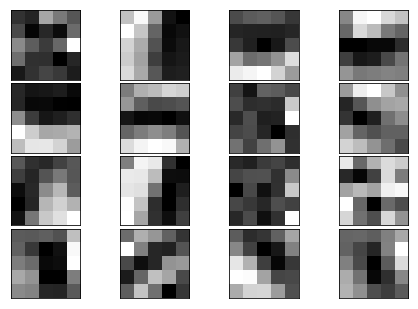

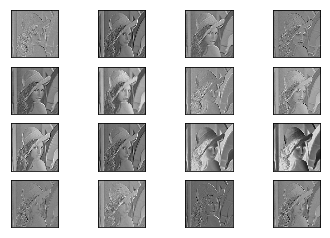

In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet
from matplotlib.image import imread
from common.layers import Convolution

def filter_show(filters, nx=4, show_num=16):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(show_num / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(show_num):
        ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')


network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 学習後の重み
network.load_params("params.pkl")

filter_show(network.params['W1'], 16)

img = imread('../dataset/lena_gray.png')
img = img.reshape(1, 1, *img.shape)

fig = plt.figure()

w_idx = 1

for i in range(16):
    w = network.params['W1'][i]
    b = 0  # network.params['b1'][i]

    w = w.reshape(1, *w.shape)
    #b = b.reshape(1, *b.shape)
    conv_layer = Convolution(w, b) 
    out = conv_layer.forward(img)
    out = out.reshape(out.shape[2], out.shape[3])
    
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    ax.imshow(out, cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

# visualize_filter.py

In [ ]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])